# Initialize the Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
#os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import scipy.sparse as sp
from sklearn import manifold
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams


import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf
os.chdir('./Analysis_Notebooks/')

path_MetaData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Raw_Neocortical'
path_CoreData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Dyne_Neocortical/FuncConn.XCorr_WideBand.4_115/network'
path_PeriphData = '/home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph'
path_InpData_Cons = path_PeriphData + '/ds-e03-NMF_Consensus'
path_InpData_Cocl = path_PeriphData + '/ds-e04-NMF_CoCluster'
path_ExpData = path_PeriphData + '/ds-e05-Subgraph_State_Stats'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Generate Data List

In [2]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_MetaData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]

sz_type = {'HUP64': ['CP+GTC'],
           'HUP65': ['CP+GTC'],
           'HUP68': ['CP', 'CP+GTC'],
           'HUP70': ['SP'],
           'HUP72': ['CP+GTC'],
           'HUP73': ['CP+GTC'],
           'HUP78': ['CP'],
           'HUP79': ['CP'],
           'HUP86': ['CP+GTC'],
           'HUP87': ['CP'],
           'MAYO004': ['CP+GTC'],
           'MAYO006': ['CP'],
           'MAYO010': ['CP'],
           'MAYO011': ['CP', 'CP+GTC'],
           'MAYO016': ['CP+GTC'],
           'MAYO019': ['CP+GTC'],
           'MAYO020': ['CP+GTC'],
           'MAYO023': ['CP'],
           'MAYO026': ['CP'],
           'MAYO031': ['CP+GTC'],
           'MAYO033': ['GA'],
           'MAYO037': ['CP']}
sz_class = {'PS': ['HUP78', 'HUP79', 'HUP87',
                   'MAYO006', 'MAYO010', 'MAYO023',
                   'MAYO026', 'MAYO037'],
            'PS+GTC': ['HUP64', 'HUP65', 'HUP72', 'HUP73', 'HUP86',
                       'MAYO004', 'MAYO016', 'MAYO019', 'MAYO020',
                       'MAYO031']}

subj_dict = {}
for subj_ii, subj_id in enumerate(meta_subj):        
    print('{}'.format(subj_id))
        
    # Get the block and cluster assignments
    try:
        block_expr = np.load('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_InpData_Cocl, subj_id))['expr_ensemble_matr']
        
        block_epoch = np.load('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_InpData_Cocl, subj_id))['block_ensemble_matr']
        block_epoch_null = np.load('{}/NMF_Subgraph_Ensemble.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['block_ensemble_matr']
        
        clust = np.load('{}/NMF_Subgraph_States.{}.npz'.format(path_InpData_Cocl, subj_id))['states']
        clust_null = np.load('{}/NMF_Subgraph_States.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['states']
        
        block_locs = np.load('{}/NMF_Subgraph_Projection.{}.npz'.format(path_InpData_Cocl, subj_id))['block_locs']        
        block_locs_null = np.load('{}/NMF_Subgraph_Projection.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['block_locs']        
    except IOError:
        continue
        
    subj_dict[subj_id] = {}
    subj_dict[subj_id]['Real_Cluster'] = {}
    subj_dict[subj_id]['Null_Cluster'] = {}    
        
    subj_dict[subj_id]['Real_Cluster']['epoch_expr'] = block_expr
    
    subj_dict[subj_id]['Real_Cluster']['epoch_full_lbl'] = block_epoch
    subj_dict[subj_id]['Null_Cluster']['epoch_full_lbl'] = block_epoch_null
    
    subj_dict[subj_id]['Real_Cluster']['epoch_lbl'] = np.array([epoch_str.split('.')[1] for epoch_str in block_epoch])
    subj_dict[subj_id]['Null_Cluster']['epoch_lbl'] = np.array([epoch_str.split('.')[1] for epoch_str in block_epoch_null])

    subj_dict[subj_id]['Real_Cluster']['epoch_id'] = np.unique(subj_dict[subj_id]['Real_Cluster']['epoch_lbl'])  
    subj_dict[subj_id]['Null_Cluster']['epoch_id'] = np.unique(subj_dict[subj_id]['Null_Cluster']['epoch_lbl'])
    
    subj_dict[subj_id]['Real_Cluster']['clust_lbl'] = clust
    subj_dict[subj_id]['Null_Cluster']['clust_lbl'] = clust_null

    subj_dict[subj_id]['Real_Cluster']['clust_id'] = np.unique(clust)
    subj_dict[subj_id]['Null_Cluster']['clust_id'] = np.unique(clust_null)
    
    subj_dict[subj_id]['Real_Cluster']['n_clust'] = len(subj_dict[subj_id]['Real_Cluster']['clust_id'])
    subj_dict[subj_id]['Null_Cluster']['n_clust'] = len(subj_dict[subj_id]['Null_Cluster']['clust_id'])    
        
    subj_dict[subj_id]['Real_Cluster']['projection'] = block_locs
    subj_dict[subj_id]['Null_Cluster']['projection'] = block_locs_null  

n_subj = len(subj_dict.keys())
subj_key = np.sort(subj_dict.keys())    

HUP64
HUP65
HUP68
HUP70
HUP72
HUP73
HUP78
HUP79
HUP86
HUP87
MAYO004
MAYO006
MAYO010
MAYO011
MAYO012
MAYO014
MAYO016
MAYO019
MAYO020
MAYO023
MAYO026
MAYO028
MAYO030
MAYO031
MAYO033
MAYO037


# Number of Clusters

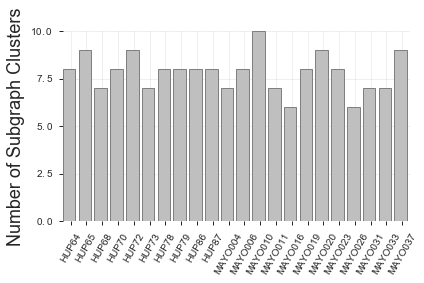

In [4]:
%matplotlib inline

plt.figure()
ax = plt.subplot(111)

for ii, subj_id in enumerate(subj_key):
    ax.bar(ii, subj_dict[subj_id]['Real_Cluster']['n_clust'])

ax.set_xlim([0, n_subj])    
plt.xticks(np.linspace(0.5, n_subj-0.5, n_subj),
           subj_key,
           rotation=60)
ax.xaxis.set_ticks_position('bottom')


ticks = ax.get_yticks()
ax.set_yticks(np.linspace(ticks[0], ticks[-1], 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of Subgraph Clusters')

plt.savefig('./e05-Figures/Num_Subgraph_Clusters.svg')

# Subgraph Projection

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


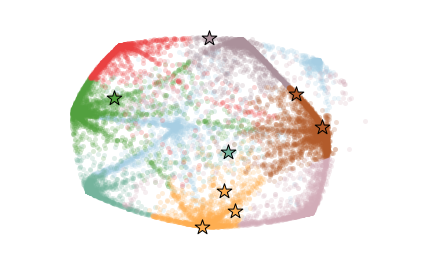

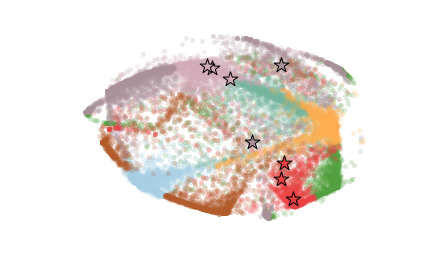

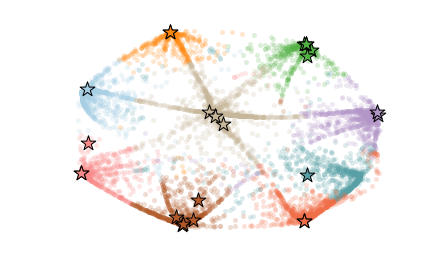

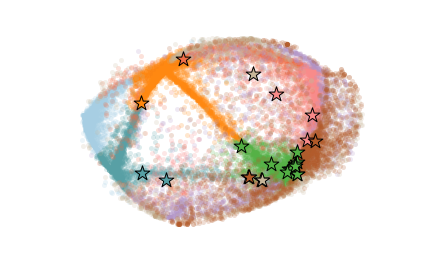

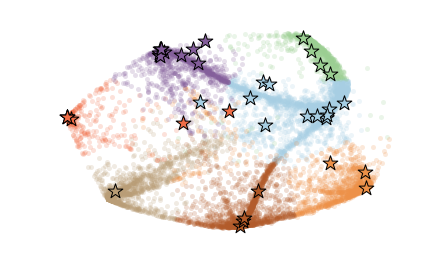

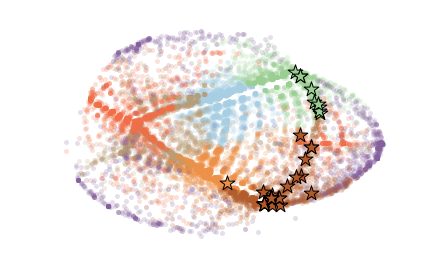

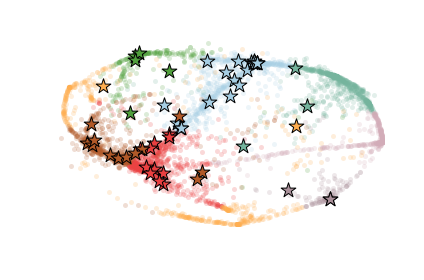

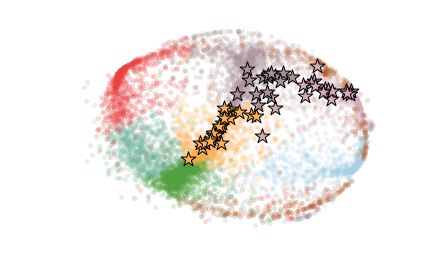

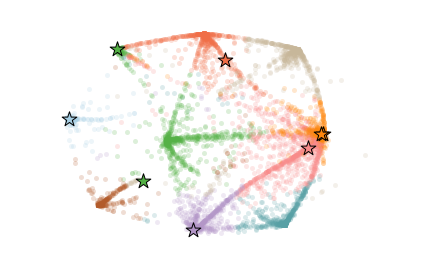

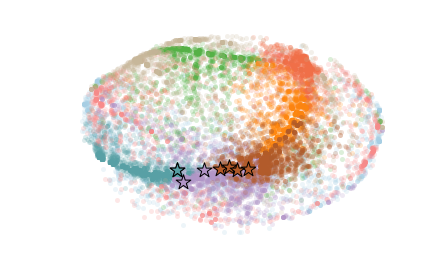

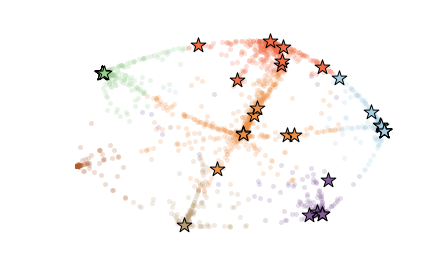

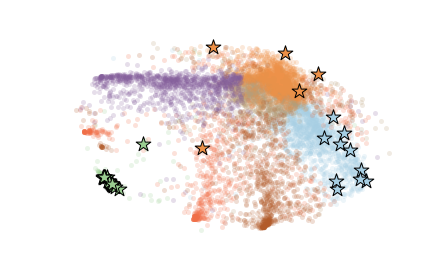

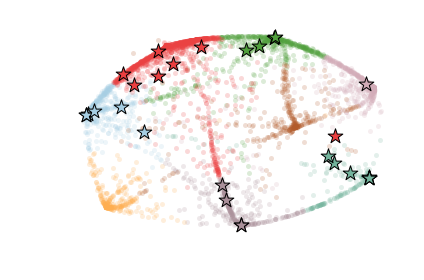

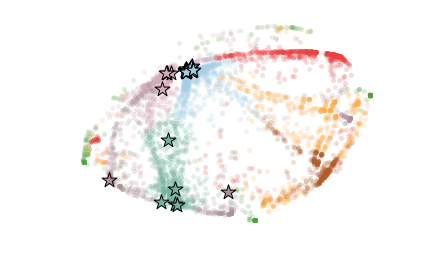

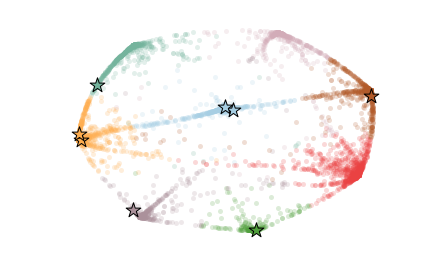

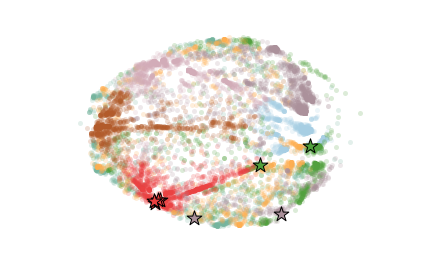

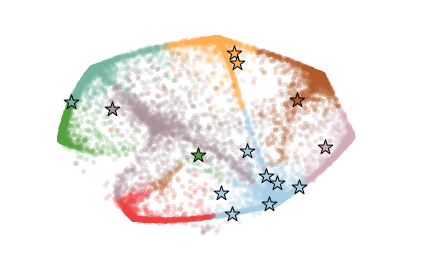

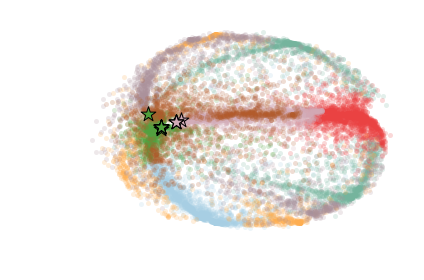

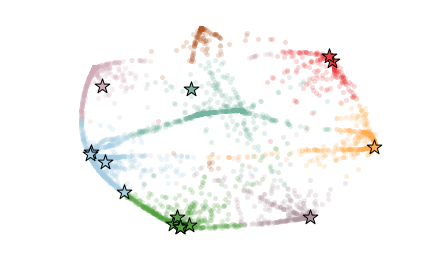

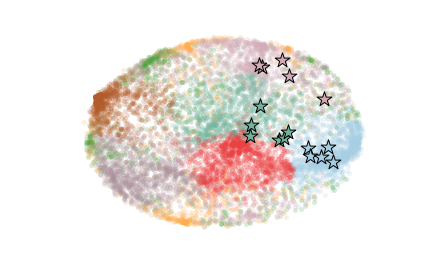

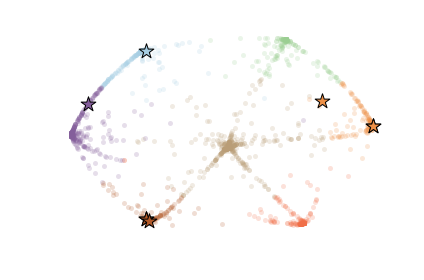

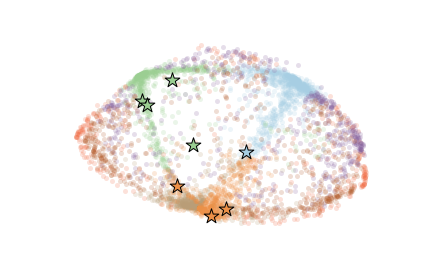

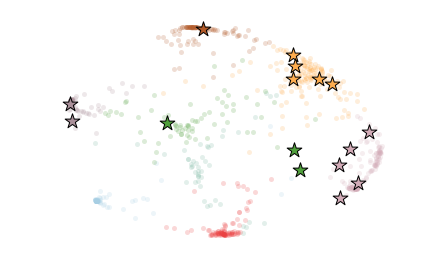

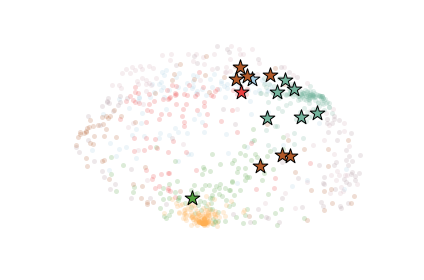

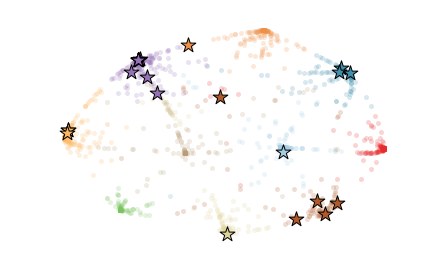

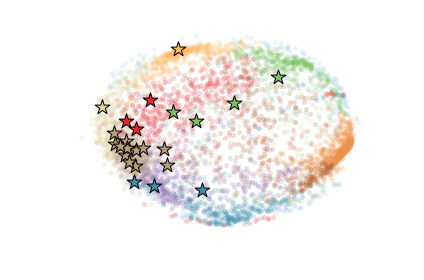

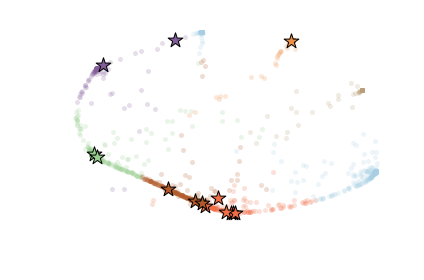

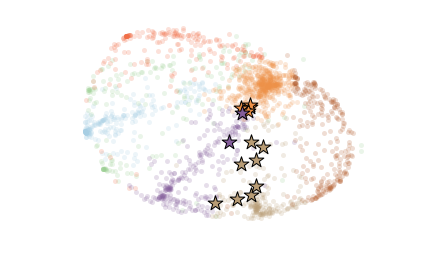

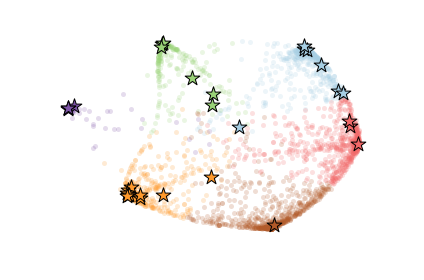

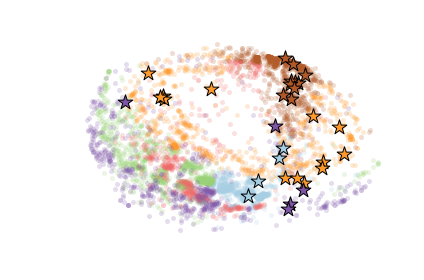

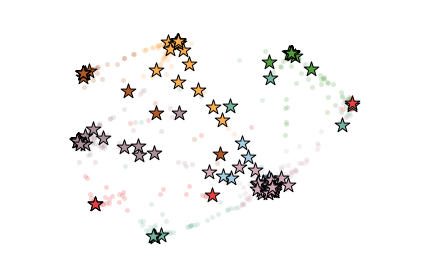

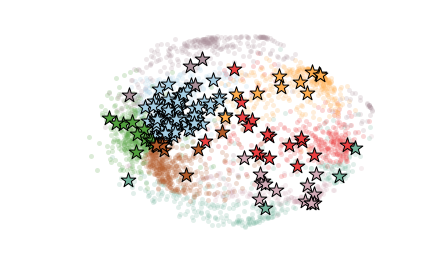

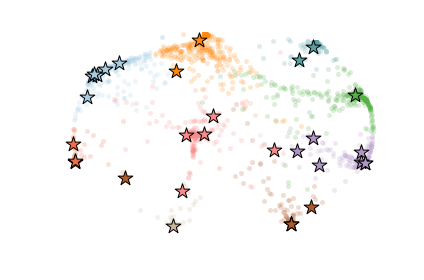

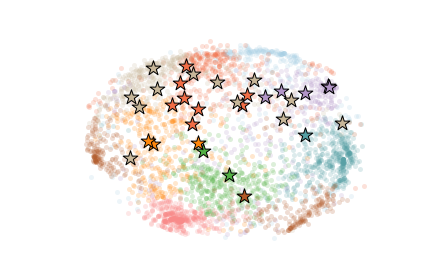

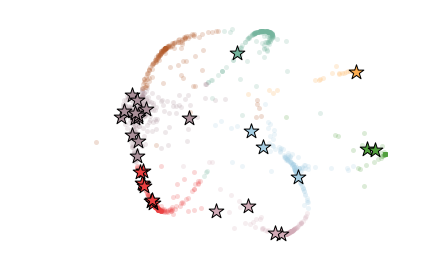

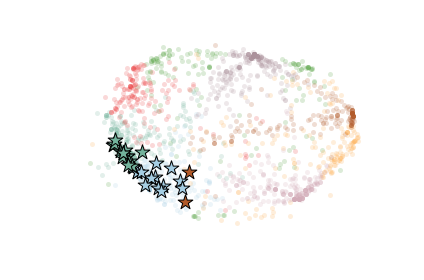

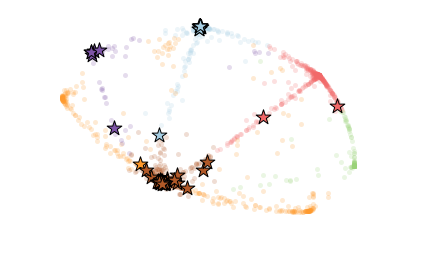

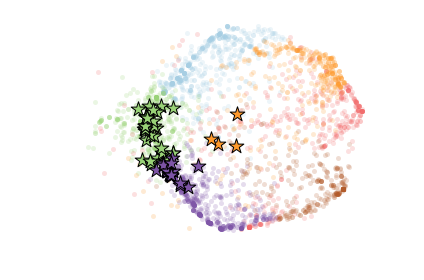

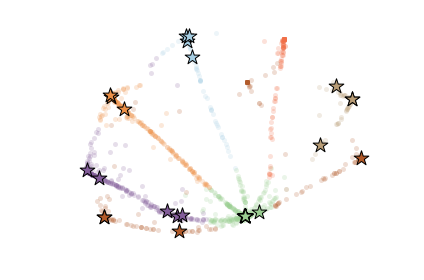

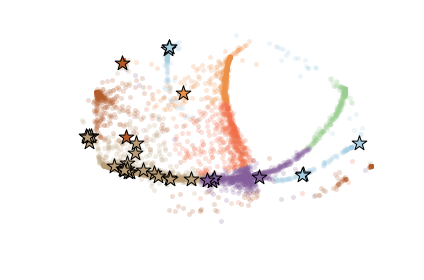

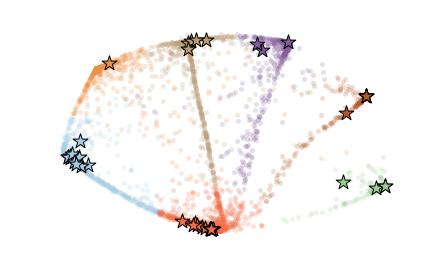

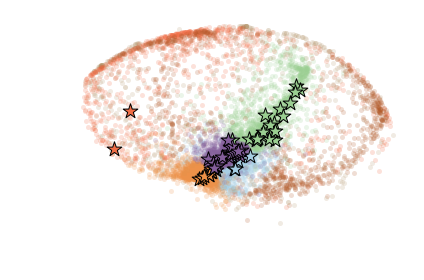

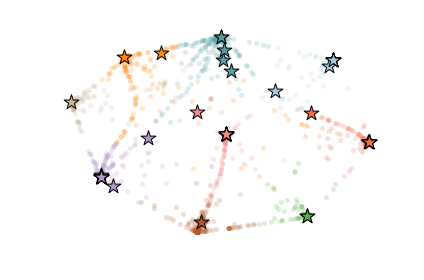

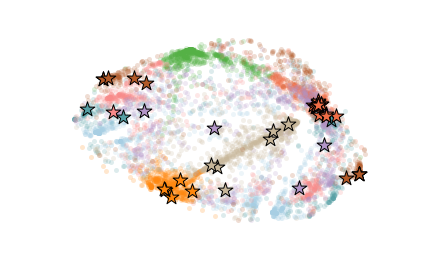

In [3]:
%matplotlib inline

for ii, subj_id in enumerate(subj_key):

    # Handle Colormap
    cmap = plt.cm.get_cmap('Paired')
    cmaplist = [cmap(i) for i in range(cmap.N)]
    #cmaplist = cmaplist[10:-10]

    cmap = cmap.from_list('Custom', cmaplist, subj_dict[subj_id]['Real_Cluster']['n_clust'])
    bounds = np.linspace(0, subj_dict[subj_id]['Real_Cluster']['n_clust'], 
                         subj_dict[subj_id]['Real_Cluster']['n_clust']+1)
    cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)    
    clr_in = cmap(np.arange(subj_dict[subj_id]['Real_Cluster']['n_clust']))
    
    # Handle epoch-specific plotting params
    marker = {'interictal': '.',
              'preictal': '.',
              'ictal': '*'}
    m_size = {'interictal': 100,
               'preictal': 240,
               'ictal': 240}    
    alpha = {'interictal': 0.2,
              'preictal': 1.0,
              'ictal': 1.0}
    clr_out = {'interictal': 0.0,
               'preictal': 1.0,
               'ictal': 1.0}
    
    # Plot the Real Subgraph Space
    fig = plt.figure()
    ax = plt.subplot(111)
    for ep_id in ['interictal', 'ictal']:
        ep_ix = np.flatnonzero(subj_dict[subj_id]['Real_Cluster']['epoch_lbl'] == ep_id)
        
        for cl_id in subj_dict[subj_id]['Real_Cluster']['clust_id']:
            cl_ix = np.flatnonzero(subj_dict[subj_id]['Real_Cluster']['clust_lbl'] == cl_id)
            
            pt_ix = np.intersect1d(ep_ix, cl_ix)
            ax.scatter(subj_dict[subj_id]['Real_Cluster']['projection'][pt_ix, 0],
                       subj_dict[subj_id]['Real_Cluster']['projection'][pt_ix, 1],
                       s=m_size[ep_id], marker=marker[ep_id], lw=clr_out[ep_id],
                       edgecolors='k', color=clr_in[cl_id, :], 
                       alpha=alpha[ep_id])
    ax.set_axis_off()
    #ax.set_title(subj_id)

    # Add a colorbar
    #ax_cb = fig.add_axes([0.20, 0.1, 0.6, 0.025])
    #mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=cnorm,
    #                            spacing='proportional',
    #                            boundaries=bounds,
    #                            orientation='horizontal',
    #                            ticks=[])
    
    plt.savefig('./e05-Figures/Subgraph_Projection.{}.png'.format(subj_id))    
    
    
    
    # Plot the Real Subgraph Space    
    fig = plt.figure()    
    ax = plt.subplot(111)
    for ep_id in ['interictal', 'ictal']:
        ep_ix = np.flatnonzero(subj_dict[subj_id]['Null_Cluster']['epoch_lbl'] == ep_id)
        
        for cl_id in subj_dict[subj_id]['Null_Cluster']['clust_id']:
            cl_ix = np.flatnonzero(subj_dict[subj_id]['Null_Cluster']['clust_lbl'] == cl_id)
            
            pt_ix = np.intersect1d(ep_ix, cl_ix)
            ax.scatter(subj_dict[subj_id]['Null_Cluster']['projection'][pt_ix, 0],
                       subj_dict[subj_id]['Null_Cluster']['projection'][pt_ix, 1],
                       s=m_size[ep_id], marker=marker[ep_id], lw=clr_out[ep_id],
                       edgecolors='k', color=clr_in[cl_id, :], 
                       alpha=alpha[ep_id])
    ax.set_axis_off()
    #ax.set_title(subj_id + ' Null')
    
    # Add a colorbar
    #ax_cb = fig.add_axes([0.20, 0.1, 0.6, 0.025])
    #mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=cnorm,
    #                            spacing='proportional',
    #                            boundaries=bounds,
    #                            orientation='horizontal',
    #                            ticks=[])

    plt.savefig('./e05-Figures/Subgraph_Projection.NULL.{}.png'.format(subj_id))

    plt.show()

# Normalized Projection Distance to Cluster Centroid

In [293]:
def norm_proj_dist_to_centroid(sample_pos, in_pos, out_pos):
    
    dist_to_in = \
        np.sqrt((in_pos[0]-sample_pos[0])**2 + \
                (in_pos[1]-sample_pos[1])**2)
        
    dist_to_out = []
    for pos in out_pos:
        dist_to_out.append(
            np.sqrt((pos[0]-sample_pos[0])**2 + \
                    (pos[1]-sample_pos[1])**2))
    dist_to_out = np.min(dist_to_out)
         
    return (dist_to_out - dist_to_in) / (dist_to_out + dist_to_in)

data_table = {'Subject': [],
              'Model': [],
              'Epoch': [],
              'Block_Ix': [],
              'Cluster_ID': [],              
              'D2C': []}

for subj_ii, subj_id in enumerate(subj_key):
    print(subj_id)
    
    for model_id in ['Real_Cluster', 'Null_Cluster']:
        # Compute population centroid position
        pop_centroid_pos = np.mean(subj_dict[subj_id][model_id]['projection'], axis=0)
    
        # Compute cluster centroid position
        cluster_centroid_pos = {}
        for cl_id in subj_dict[subj_id][model_id]['clust_id']:
            cl_ix = np.flatnonzero(subj_dict[subj_id][model_id]['clust_lbl'] == cl_id)
            cluster_centroid_pos[cl_id] = np.mean(subj_dict[subj_id][model_id]['projection'][cl_ix, :], axis=0)
        
        # Find epoch type
        for epoch_id in ['ictal', 'interictal']:
            ep_ix = np.flatnonzero(subj_dict[subj_id][model_id]['epoch_lbl'] == epoch_id)
        
            for pt_ix in ep_ix:

                # Cluster ID for the sample
                cl_id = subj_dict[subj_id][model_id]['clust_lbl'][pt_ix]
                in_cluster_centroid_pos = cluster_centroid_pos[cl_id]
                out_cluster_centroid_pos = [cluster_centroid_pos[non_cl_id]
                                            for non_cl_id in np.setdiff1d(cluster_centroid_pos.keys(), [cl_id])]

                # Normalize projection distance to cluster centroid for sample
                sample_pos = subj_dict[subj_id][model_id]['projection'][pt_ix, :]
                
                norm_dist = norm_proj_dist_to_centroid(sample_pos,
                                                       in_cluster_centroid_pos,
                                                       out_cluster_centroid_pos)
                
                data_table['Subject'].append(subj_id)
                data_table['Model'].append(model_id)
                data_table['Epoch'].append(epoch_id)
                data_table['Block_Ix'].append(pt_ix)
                data_table['Cluster_ID'].append(cl_id)
                data_table['D2C'].append(norm_dist)

# Save Data Table for R-stats
df = pd.DataFrame(data_table, columns=data_table.keys())
df.to_csv('./e05-R_Stats/subgraph_integration.csv')

HUP64
HUP65
HUP68
HUP70
HUP72
HUP73
HUP78
HUP79
HUP86
HUP87
MAYO004
MAYO006
MAYO010
MAYO011
MAYO016
MAYO019
MAYO020
MAYO023
MAYO026
MAYO031
MAYO033
MAYO037


# Cluster Cohesion

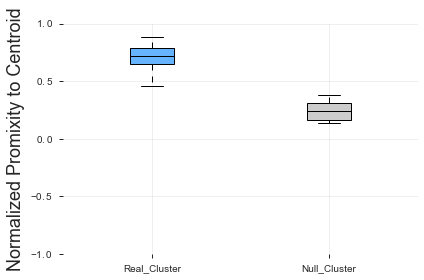

Ttest_relResult(statistic=12.085284165489799, pvalue=6.3893863687883926e-11)
(0.70958514975003073, 0.029356970636156828)
(0.24278408265341136, 0.019918137439753722)


In [49]:
df = pd.read_csv('./e05-R_Stats/subgraph_integration.csv')

# Plot the data frame
%matplotlib inline
color = {'Null_Cluster': [0.8, 0.8, 0.8],
         'Real_Cluster': [0.4, 0.7, 1]}

plt.figure()
ax = plt.subplot(111)

model_lbl = []
for model_ii, model_id in enumerate(['Real_Cluster', 'Null_Cluster']):
    sel_model = df[df['Model'] == model_id]
    sel_res = sel_model['D2C'].groupby(df['Subject']).mean()

    bplot = ax.boxplot([sel_res], positions=[model_ii],
               widths=[0.25], whis=[5, 95], patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color[model_id]])
    
    model_lbl.append(model_id)
    
ax.set_xlim([-0.5, 1.5])        
plt.xticks([0, 1],
           model_lbl)
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-1.0, 1.0])        
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Normalized Promixity to Centroid')

plt.savefig('./e05-Figures/Subgraph_Integration.svg')
plt.show()

print(stats.ttest_rel(df[df['Model'] == 'Real_Cluster']['D2C'].groupby(df['Subject']).mean(),
                      df[df['Model'] == 'Null_Cluster']['D2C'].groupby(df['Subject']).mean()))
print(df[df['Model'] == 'Real_Cluster']['D2C'].groupby(df['Subject']).mean().mean(),
      df[df['Model'] == 'Real_Cluster']['D2C'].groupby(df['Subject']).mean().std() / \
          np.sqrt(len(df[df['Model'] == 'Real_Cluster']['D2C'].groupby(df['Subject']).mean())))
print(df[df['Model'] == 'Null_Cluster']['D2C'].groupby(df['Subject']).mean().mean(),
      df[df['Model'] == 'Null_Cluster']['D2C'].groupby(df['Subject']).mean().std() / \
          np.sqrt(len(df[df['Model'] == 'Null_Cluster']['D2C'].groupby(df['Subject']).mean())))

# Ictal/Interictal Cohesion

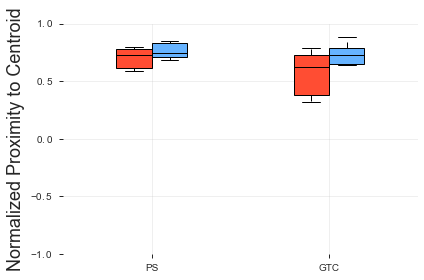

Ttest_relResult(statistic=-3.2936686067182794, pvalue=0.013235520220335164)
(0.7008759429515512, 0.038865379862740551)
(0.76352376543018197, 0.033378745452992103)
(8, 8)

Ttest_relResult(statistic=-4.259770393946571, pvalue=0.0021118617234998889)
(0.57096255889521885, 0.061245501072235697)
(0.71327540727523264, 0.043570695764914971)
(10, 10)


In [208]:
df = pd.read_csv('./e05-R_Stats/subgraph_integration.csv')

# Plot the data frame
%matplotlib inline
color = {'interictal': [0.4, 0.7, 1],
         'ictal': [1.0, 0.3, 0.2]}

plt.figure()
ax = plt.subplot(111)

sel_model = df[df['Model'] == 'Real_Cluster']
sel_ictal = sel_model[sel_model['Epoch'] == 'ictal']['D2C'].groupby(df['Subject']).mean()
sel_interictal = sel_model[sel_model['Epoch'] == 'interictal']['D2C'].groupby(df['Subject']).mean()

bplot = ax.boxplot([sel_ictal[sz_class['PS']], sel_interictal[sz_class['PS']],
                    sel_ictal[sz_class['PS+GTC']], sel_interictal[sz_class['PS+GTC']]],
                   positions=[-0.1, 0.1, 0.9, 1.1],
                   widths=[0.2, 0.2, 0.2, 0.2], whis=[5, 95], patch_artist=True)
fig_plotting.set_box_color(bplot, 'k', [color['ictal'], color['interictal'],
                                        color['ictal'], color['interictal']])
    
ax.set_xlim([-0.5, 1.5])        
plt.xticks([0, 1],
           ['PS', 'GTC'])
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-1.0, 1.0])        
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Normalized Proximity to Centroid')

plt.savefig('./e05-Figures/Ictal_Integration.svg')
plt.show()

print(stats.ttest_rel(sel_ictal[sz_class['PS']], sel_interictal[sz_class['PS']]))
print(sel_ictal[sz_class['PS']].mean(), sel_ictal[sz_class['PS']].std() / np.sqrt(len(sel_ictal[sz_class['PS']])))
print(sel_interictal[sz_class['PS']].mean(), sel_interictal[sz_class['PS']].std() / np.sqrt(len(sel_interictal[sz_class['PS']])))
print(len(sel_ictal[sz_class['PS']]), len(sel_interictal[sz_class['PS']]))
print('')
print(stats.ttest_rel(sel_ictal[sz_class['PS+GTC']], sel_interictal[sz_class['PS+GTC']]))
print(sel_ictal[sz_class['PS+GTC']].mean(), sel_ictal[sz_class['PS+GTC']].std() / np.sqrt(len(sel_ictal[sz_class['PS+GTC']])))
print(sel_interictal[sz_class['PS+GTC']].mean(), sel_interictal[sz_class['PS+GTC']].std() / np.sqrt(len(sel_interictal[sz_class['PS+GTC']])))
print(len(sel_ictal[sz_class['PS+GTC']]), len(sel_interictal[sz_class['PS+GTC']]))

# State Expression Frequency

In [48]:
import scipy.signal as sig

fft_len = np.arange(10, 331, 20)
for flen in fft_len:
    print(flen)
    
    df = pd.read_csv('./e05-R_Stats/subgraph_integration.csv')

    # Plot the data frame
    %matplotlib inline

    data_table = {'Subject': [],
                  'Epoch': [],
                  'Freq': [],
                  'PSD': []}

    for subj_ii, subj_id in enumerate(np.unique(df['Subject'])):    
        #print(subj_id)
        sel_subj = df[df['Subject'] == subj_id]

        sel_model = sel_subj[df['Model'] == 'Real_Cluster']

        for epoch_ii, epoch_id in enumerate(np.unique(df['Epoch'])):
            sel_epoch = sel_model[df['Epoch'] == epoch_id]        

            for block_ix in sel_epoch['Block_Ix']:
                sel_block = sel_epoch[df['Block_Ix'] == block_ix]

                # Determine maximal expression
                expr = subj_dict[subj_id]['Real_Cluster']['epoch_expr'][block_ix]
                expr /= expr.max()

                # Compute Power Spectrum
                if len(expr) < flen:
                    expr_long = np.zeros(flen)
                    expr_long[:len(expr)] = expr[...]
                else:
                    expr_long = expr 
                freq, pxx = sig.welch(expr_long, fs=1.0, nperseg=flen, nfft=flen)

                for ff, pp in zip(freq, pxx):
                    data_table['Subject'].append(subj_id)
                    data_table['Epoch'].append(epoch_id)        
                    data_table['Freq'].append(ff)
                    data_table['PSD'].append(pp)

    # Save Data Table for R-stats
    df = pd.DataFrame(data_table, columns=data_table.keys())
    df.to_csv('./e05-R_Stats/ictal_frequency-{}.csv'.format(flen))

10


/mnt/castor/seas_home/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/mnt/castor/seas_home/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/ipykernel/__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/mnt/castor/seas_home/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330


FFT Length: 10 | True Difference: 0.0068489574213 | PVal: 0.396
FFT Length: 30 | True Difference: 0.0223726810841 | PVal: 0.0
FFT Length: 50 | True Difference: 0.0370076047859 | PVal: 0.0
FFT Length: 70 | True Difference: 0.047960909284 | PVal: 0.0
FFT Length: 90 | True Difference: 0.0524453413055 | PVal: 0.0
FFT Length: 110 | True Difference: 0.0548392640201 | PVal: 0.0
FFT Length: 130 | True Difference: 0.0574050452885 | PVal: 0.0
FFT Length: 150 | True Difference: 0.0575941441945 | PVal: 0.0
FFT Length: 170 | True Difference: 0.0570495756398 | PVal: 0.0
FFT Length: 190 | True Difference: 0.0579573638286 | PVal: 0.0
FFT Length: 210 | True Difference: 0.057260647767 | PVal: 0.0
FFT Length: 230 | True Difference: 0.0561828710783 | PVal: 0.0
FFT Length: 250 | True Difference: 0.0550952120687 | PVal: 0.0
FFT Length: 270 | True Difference: 0.0540744497559 | PVal: 0.0
FFT Length: 290 | True Difference: 0.0533370033574 | PVal: 0.0
FFT Length: 310 | True Difference: 0.0526543098865 | PVal: 0

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


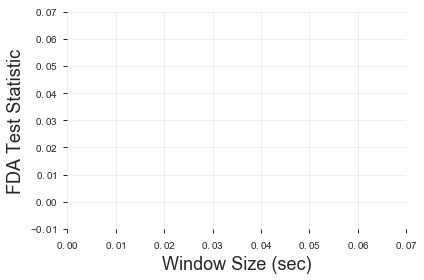

In [3]:
# Compute FDA for each Window Size
true_diff_flen = []
null_diff_flen_upper = []
null_diff_flen_median = []
null_diff_flen_lower = []

fft_len = np.arange(10, 331, 20)
for flen in fft_len:

    df = pd.read_csv('./e05-R_Stats/ictal_frequency-{}.csv'.format(flen))
    sel_psd = df['PSD'].groupby([df['Epoch'], df['Subject'], df['Freq']]).mean()
    subj = np.intersect1d(sel_psd.unstack().T['ictal'].keys(),
                          sel_psd.unstack().T['interictal'].keys())
    freq = np.unique(sel_psd.index.get_level_values('Freq'))

    sel_psd_ictal = sel_psd.unstack().T['ictal'][subj].T
    sel_psd_interictal = sel_psd.unstack().T['interictal'][subj].T

    # FDA
    psd_interictal = np.array(sel_psd_interictal)
    psd_ictal = np.array(sel_psd_ictal)
    psd_all = np.concatenate((psd_interictal, psd_ictal))
    n_subj = psd_ictal.shape[0]

    true_diff = np.mean(np.abs(psd_ictal.mean(axis=0) -
                               psd_interictal.mean(axis=0)))

    null_diff = []
    for n_i in xrange(1000):
        psd_all_perm = np.random.permutation(psd_all)
        psd_interictal_perm = psd_all_perm[:n_subj, :]
        psd_ictal_perm = psd_all_perm[n_subj:, :]

        null_diff.append(np.mean(np.abs(psd_ictal_perm.mean(axis=0) -
                                        psd_interictal_perm.mean(axis=0))))
    null_diff = np.array(null_diff)
    pv = np.mean(null_diff > true_diff)
    
    print('FFT Length: {} | True Difference: {} | PVal: {}'.format(flen, true_diff, pv))
    
    true_diff_flen.append(true_diff)    
    null_diff_flen_upper.append(np.percentile(null_diff, 95))
    null_diff_flen_median.append(np.percentile(null_diff, 50))    
    null_diff_flen_lower.append(np.percentile(null_diff, 5))
    
%matplotlib inline    
plt.figure()
ax = plt.subplot(111)
ax.scatter(fft_len, true_diff_flen)
ax.plot(fft_len, true_diff_flen)
ax.plot(fft_len, null_diff_flen_median, 'k')
ax.fill_between(fft_len, null_diff_flen_upper, null_diff_flen_lower)

ax.set_xlim([0, 350])
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Window Size (sec)')

ax.set_ylim([0, 0.07])
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('FDA Test Statistic')

plt.savefig('./e05-Figures/Expression.PSD.WindowSize.svg')

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


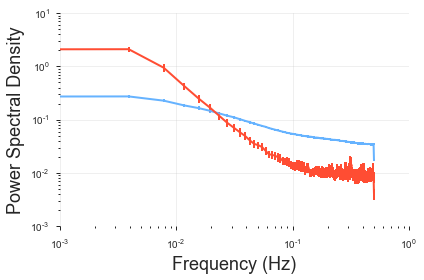

In [2]:
# Plot PSD
%matplotlib inline
color = {'interictal': [0.4, 0.7, 1],
         'ictal': [1.0, 0.3, 0.2]}

df = pd.read_csv('./e05-R_Stats/ictal_frequency.csv')
sel_psd = df['PSD'].groupby([df['Epoch'], df['Subject'], df['Freq']]).mean()
subj = np.intersect1d(sel_psd.unstack().T['ictal'].keys(),
                      sel_psd.unstack().T['interictal'].keys())
freq = np.unique(sel_psd.index.get_level_values('Freq'))

sel_psd_ictal = sel_psd.unstack().T['ictal'][subj].T
sel_psd_interictal = sel_psd.unstack().T['interictal'][subj].T

psd_ictal_mean = np.array(sel_psd_ictal.mean())
psd_ictal_std = np.array(sel_psd_ictal.std())
psd_interictal_mean = np.array(sel_psd_interictal.mean())
psd_interictal_std = np.array(sel_psd_interictal.std())

plt.figure()
ax = plt.subplot(111)
ax.errorbar(freq, psd_interictal_mean, 
            yerr=psd_interictal_std / np.sqrt(len(subj)),
            color=color['interictal'])
ax.errorbar(freq, psd_ictal_mean, 
            yerr=psd_ictal_std / np.sqrt(len(subj)),
            color=color['ictal'])

#ax.set_xlim([-0.05, 0.55])
ax.set_xlabel('Frequency (Hz)')
ax.set_xscale('log')
ax.xaxis.set_ticks_position('bottom')

#ax.set_ylim([0.0, 0.15])        
#ax.set_yticks(np.linspace(0.0, 0.2, 5))
ax.yaxis.set_ticks_position('left')
ax.set_yscale('log')
ax.set_ylabel('Power Spectral Density')

plt.savefig('./e05-Figures/Expression.PSD.svg')
plt.show()

In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.errorbar(freq, psd_interictal_mean, 
            yerr=psd_interictal_std / np.sqrt(len(subj)),
            color=color['interictal'])
ax.errorbar(freq, psd_ictal_mean, 
            yerr=psd_ictal_std / np.sqrt(len(subj)),
            color=color['ictal'])

#ax.set_xlim([-0.05, 0.55])
ax.set_xlabel('Frequency (Hz)')
ax.set_xscale('log')
ax.xaxis.set_ticks_position('bottom')

#ax.set_ylim([0.0, 0.15])        
#ax.set_yticks(np.linspace(0.0, 0.2, 5))
ax.yaxis.set_ticks_position('left')
ax.set_yscale('log')
ax.set_ylabel('Power Spectral Density')

plt.savefig('./e05-Figures/Expression.PSD.svg')
plt.show()